In [2]:
#Modules
import numpy as np
import matplotlib.pyplot as plt
import scipy as sc
import sympy as sy
import random as rd
import pandas as pd

# Setting up the model
We will use a restricted Boltzmann machine with $M$ visible nodes and 1 hidden node. We represent the weights with an adjacency matrix and the node values with a feature vector. The restricted Boltzmann machine is a bipartite graph, thus we can easily construct the adjacency matrix with the feature vectors when we order with visible nodes first, then hidden nodes. 

In [3]:
#Model generating true feature vector / set of weights / set of coupling constants
#Generate no_feature_vec models with different feature vectors randomly
def Generate_teacher_models(no_teacher_models, no_visible_nodes:int, seed:int=100 , no_hidden_nodes:int= 1, binary:bool=True):
    rd.seed(seed)
    np.random.seed(seed)
    teacher_models_adj_mat=[]
    teacher_models_feature_mat=[]
    for i in range(no_teacher_models):
        if binary:
            # for binary weights
            feature_mat=np.random.choice([-1,1], size=(no_visible_nodes, no_hidden_nodes))
        else:
            #for cotinuous weights from -1 to 1 with uniform probability
            feature_mat=np.random.uniform(-1,1, size=(no_visible_nodes, no_hidden_nodes))

        adj_mat=np.zeros((no_visible_nodes+no_hidden_nodes,no_visible_nodes+no_hidden_nodes))
        adj_mat[0:no_visible_nodes,no_visible_nodes:]=feature_mat
        half_mat=adj_mat.copy()
        adj_mat=half_mat+adj_mat.T

        teacher_models_adj_mat.append(adj_mat)
        teacher_models_feature_mat.append(feature_mat)

    
    return teacher_models_adj_mat, teacher_models_feature_mat


# Initialising Parameters
Initialising the number of teacher model and the number of hidden nodes to create the feature matrix(vector) and the adjaecency matrix.

In [4]:
no = 1 #Number of teacher model
M = 60 #Number of hidden node
teacher_model_adj_mat,teacher_model_feature_mat=Generate_teacher_models(no, M,seed=101)


In [5]:
print("This is the feature matirx:\n", teacher_model_feature_mat[0])

This is the feature matirx:
 [[ 1]
 [ 1]
 [ 1]
 [-1]
 [ 1]
 [ 1]
 [ 1]
 [ 1]
 [ 1]
 [ 1]
 [ 1]
 [-1]
 [-1]
 [ 1]
 [-1]
 [ 1]
 [-1]
 [-1]
 [-1]
 [-1]
 [ 1]
 [-1]
 [ 1]
 [-1]
 [ 1]
 [ 1]
 [ 1]
 [-1]
 [-1]
 [ 1]
 [ 1]
 [ 1]
 [ 1]
 [-1]
 [-1]
 [-1]
 [ 1]
 [ 1]
 [-1]
 [-1]
 [-1]
 [ 1]
 [ 1]
 [ 1]
 [-1]
 [ 1]
 [ 1]
 [ 1]
 [ 1]
 [-1]
 [-1]
 [-1]
 [ 1]
 [ 1]
 [-1]
 [ 1]
 [ 1]
 [-1]
 [-1]
 [-1]]


In [6]:
print("This is the adjacency matrix:\n",np.array(teacher_model_adj_mat[0]))

This is the adjacency matrix:
 [[ 0.  0.  0. ...  0.  0.  1.]
 [ 0.  0.  0. ...  0.  0.  1.]
 [ 0.  0.  0. ...  0.  0.  1.]
 ...
 [ 0.  0.  0. ...  0.  0. -1.]
 [ 0.  0.  0. ...  0.  0. -1.]
 [ 1.  1.  1. ... -1. -1.  0.]]


Initialising the functions for Metropolis Algorithm for the Monte Carlo

In [7]:
def Hamiltonian(nodes, adj_mat):
    if len(nodes)!=len(adj_mat):
        print("NOOOOO! number of nodes not eq to size of adj_mat!!!")
        print(adj_mat)
        print(nodes)
    H=-nodes@adj_mat@nodes.T
    return H

def transition_probability(nodes,new_nodes,adj_mat,inv_temperature):
    adj_mat=adj_mat.copy()
    H_new=Hamiltonian(nodes=new_nodes,adj_mat=adj_mat)
    H=Hamiltonian(nodes=nodes,adj_mat=adj_mat)
    diff_H=H_new-H
    if diff_H < 0 :
        return 1
    else:
        return np.exp(-inv_temperature*diff_H)

def concat_sublist(mylist):
    return [item for sublist in mylist for item in sublist]

# Metropolis Algorithm
1. Initialise the Adjacency Matrix for nodes in state $s$
2. Flip a random node to determined the next step state $s'$
3. Calculate the energy change when the node is flipped
4. If the energy change,$\Delta E \leq 0$, update state $s=s'$
5. Else, flip the spin only if $\exp{(\Delta E/k_bT)} \geq r$ where $r$ is a random number such that $0<r<1$
6. Repeat steps 1 to 5, until equilibrium has reached


# Determining Equilibrium and Sampling
Equilibrium is determined by checking the correlation coefficient within a moving window. To ensure the each collected sample are uncorrelated, we will identify how many Monte Carlo sweeps will be sufficient, $\delta t$. Then, collect samples every $\delta t$

In [8]:
#Metropolis algo
def metropolis(no_sample, adj_mat, inv_temperature, window_size, no_of_nodes, ensemble_size, window_r_limit, seed:int=102, printing:bool=False):
    adj_mat=adj_mat.copy()
    eqm=0 #becomes 1 when eqm is reached
    counter=0 #time
    samples=[] #samples to be collected
    delta_t_found=0

    #generate initial set of nodes/ data vector/ set of neuron activations
    rd.seed(seed)
    np.random.seed(seed)
    initial_nodes=np.random.choice([-1,1], size=no_of_nodes)
    
    #create an ensemble of data vectors
    nodes_ensemble=[initial_nodes.copy() for i in range(ensemble_size)]
    
    #calculate the Hamiltonians for each data vector in the ensemble at time=0
    nodes=initial_nodes.copy()
    H_timeseries_ensemble=[]
    H_timeseries_ensemble.append([Hamiltonian(nodes=nodes_ensemble[i],adj_mat=adj_mat) for i in range(ensemble_size)])
    
    while len(samples) < no_sample:
        for i in range(ensemble_size):
            nodes=nodes_ensemble.copy()[i]

            #create flipped node
            flipped_nodes=nodes.copy()
            random_index = np.random.randint(0, len(flipped_nodes))
            flipped_nodes[random_index]*=(-1)

            #determining transition
            if transition_probability(nodes=nodes,new_nodes=flipped_nodes,adj_mat=adj_mat,inv_temperature=inv_temperature) > np.random.rand():
                nodes=flipped_nodes #updating nodes to the flipped nodes
            
            #update the ensemble of set of nodes
            nodes_ensemble[i]=nodes

        #calculate the Hamiltonians for each data vector in the ensemble at time>0
        H_timeseries_ensemble.append([Hamiltonian(nodes=nodes_ensemble[i],adj_mat=adj_mat) for i in range(ensemble_size)])
            
        #determine whether equilibrium is reached by checking that the Pearson correlation coefficient is less than a defined value
        if counter>window_size and eqm==0:
            window=concat_sublist(H_timeseries_ensemble[-window_size:])
            x=concat_sublist([[i]*ensemble_size for i in range(window_size)])
            window_r=np.corrcoef(x,window)[0,1]
            if abs(window_r)<window_r_limit:
                eqm=1
                if printing:
                    print("Eqm reached at t=",counter)
                t_eqm=counter-window_size
            if np.std(np.array(window),ddof=1)==0.0:
                eqm=1
                if printing:
                    print("Eqm reached at t=",counter)
                t_eqm=counter-window_size
        
                
        #find time interval to collect samples to ensure that the samples are not correlated
        if eqm==1 and delta_t_found==0:
            time_r=np.corrcoef(H_timeseries_ensemble[counter],H_timeseries_ensemble[t_eqm])[0,1]
            if time_r < 1/np.e or np.std(np.array(H_timeseries_ensemble[counter]))==0 or np.std(np.array(H_timeseries_ensemble[t_eqm]))==0:
                delta_t=counter-t_eqm
                if printing:
                    print("delta_t found to be", delta_t)
                delta_t_found=1

        #collect samples
        if eqm==1 and delta_t_found==1:
            if counter%delta_t==0:
                samples.append(nodes_ensemble[0])
                if printing:
                    print("Added")
                if len(samples)==1:
                    t_first_sample=counter
                if len(samples)==no_sample:
                    t_last_sample=counter

        counter+=1

        if counter%no_of_nodes==0 and printing:
            print("MCS=",counter//no_of_nodes)
    
    return samples, t_eqm, delta_t, t_first_sample, t_last_sample, H_timeseries_ensemble

#t1 and t2(inculisve) defines the window size we want to plot, Y is an ensemble of time series data (i.e. a list of lists)
def plotting_random_walks_ensemble_of_timeseries(t1,t2,Y):
    x=np.arange(t1,t2+1)
    for times_series in Y:
        y = times_series[t1:t2+1]  # Random data for demonstration
        # Create the plot
        plt.plot(x, y)
    plt.ylabel("Hamiltonian")
    plt.xlabel("Monte Carlo Sweeps (MCS)")
    plt.title("Plot of Hamiltonian against MCS at ß=%1.2f" % beta )
    plt.show()
    return

#t1 and t2(inculisve) defines the window size we want to plot, Y is a time series of an ensemble of data (i.e. a list of lists)
def plotting_random_walks_timeseries_of_ensemble(t1,t2,Y):
    x=np.arange(t1,t2+1)
    Y=np.array(Y)
    for i in range(len(Y[0,:])):
        y = Y[t1:t2+1,i] 
        plt.plot(x, y)
    plt.ylabel("Hamiltonian")
    plt.xlabel("Monte Carlo Sweeps (MCS)")
    plt.title("Plot of Hamiltonian against MCS at ß=%1.2f" % beta)
    plt.show()
    return




# Running the Metropolis Algorithm

In [9]:
#how many samples to collect
no_of_samples = 60
#inverse temperature
beta = 0.5
#determining how large the window size will be 
window_size = 20
#number of random walk to run simultaneously
no_of_random_walks = 30
#upper bound of correlation coefficient within window
corcoeff=0.1
#seed of simulation for repetition (optional)
seed = 100


In [10]:
sample, t_eqm, delta_t, t_first_sample, t_last_sample, H_timeseries_ensemble=metropolis(no_sample=no_of_samples, adj_mat=teacher_model_adj_mat[0], inv_temperature=beta, window_size=window_size, no_of_nodes=M+1, ensemble_size=no_of_random_walks, window_r_limit=corcoeff, seed=seed, printing=True)

MCS= 1
MCS= 2
Eqm reached at t= 155
MCS= 3
delta_t found to be 55
Added
MCS= 4
Added
MCS= 5
Added
MCS= 6
Added
MCS= 7
Added
MCS= 8
Added
MCS= 9
Added
Added
MCS= 10
Added
MCS= 11
Added
MCS= 12
Added
MCS= 13
Added
MCS= 14
Added
MCS= 15
Added
MCS= 16
Added
MCS= 17
Added
MCS= 18
Added
Added
MCS= 19
Added
MCS= 20
Added
MCS= 21
Added
MCS= 22
Added
MCS= 23
Added
MCS= 24
Added
MCS= 25
Added
MCS= 26
Added
MCS= 27
Added
Added
MCS= 28
Added
MCS= 29
Added
MCS= 30
Added
MCS= 31
Added
MCS= 32
Added
MCS= 33
Added
MCS= 34
Added
MCS= 35
Added
MCS= 36
Added
Added
MCS= 37
Added
MCS= 38
Added
MCS= 39
Added
MCS= 40
Added
MCS= 41
Added
MCS= 42
Added
MCS= 43
Added
MCS= 44
Added
MCS= 45
Added
Added
MCS= 46
Added
MCS= 47
Added
MCS= 48
Added
MCS= 49
Added
MCS= 50
Added
MCS= 51
Added
MCS= 52
Added
MCS= 53
Added
MCS= 54
Added
MCS= 55
Added
Added
MCS= 56
Added


Displaying the entire random walk of the Monte Carlo Simlation

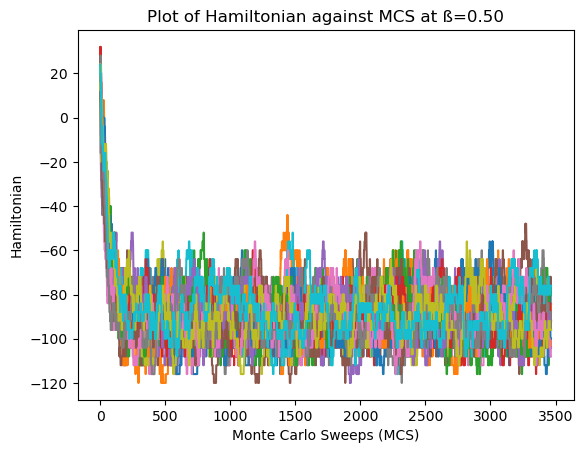

In [11]:
plotting_random_walks_timeseries_of_ensemble(t1=0,t2=t_last_sample,Y=H_timeseries_ensemble)
plt.show()

Displaying the random walk of the Monte Carlo Simulation when Equilibrium has reached (when each walk have low correlation)

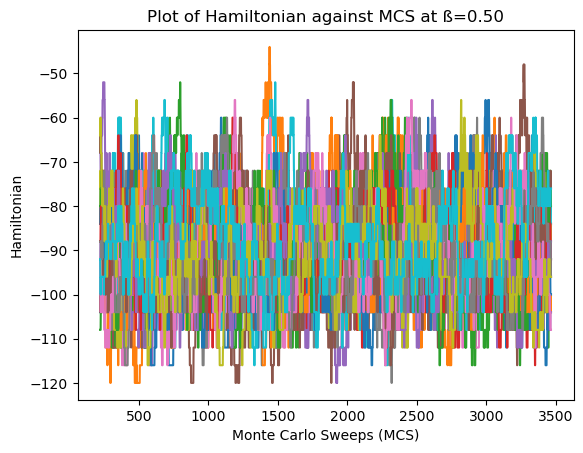

In [12]:
plotting_random_walks_timeseries_of_ensemble(t1=t_first_sample,t2=t_last_sample,Y=H_timeseries_ensemble)
plt.show()

## Message Passing for Inverse Ising problem

To reconstruct the feature vector we need to do message passing using these equations

$m_{i\rightarrow a}=\tanh{\left( \sum_{b \in \partial i \backslash \{a\}} u_{b \rightarrow i} \right)}$

$u_{b \rightarrow i}=\tanh^{-1}{\left( \tanh{\left( \beta G_{b \rightarrow i} \right)} \tanh{\left( \beta \sigma_{i}^b / \sqrt{N} \right)} \right)} $

$G_{b \rightarrow i} = \frac{1}{\sqrt{N}} \sum_{j \in \partial b \backslash \{i\}} \sigma_{jb} m_{j \rightarrow b}$

In [13]:
#Message passing equations for inverse Ising problem

def m_i_a_new_inv(u_a_i_old):
    selection_list=[np.array([[1 if i != j else 0 for j in range(len(u_a_i_old))]]) for i in range(len(u_a_i_old))]
    m_i_a_new=np.tanh(np.concatenate([selection_list[i]@u_a_i_old for i in range(len(selection_list))],axis=0)).T
    return m_i_a_new

def G_a_i_inv(m_i_a,sigma_ia):
    selection_list=[np.array([[1 if i != j else 0 for j in range(len(m_i_a))]]) for i in range(len(m_i_a))]
    G_a_i=(1/np.sqrt(len(sigma_ia)))*np.concatenate([selection_list[i]@(m_i_a*sigma_ia) for i in range(len(selection_list))],axis=0).T
    return G_a_i

def u_a_i_new_inv(G_a_i_old,sigma_ia,inv_temperature):
    return np.arctanh(np.tanh(inv_temperature*G_a_i_old)*np.tanh(inv_temperature*sigma_ia.T/np.sqrt(len(sigma_ia))))

#Message passing iteration for inverse Ising problem:
#i is the index for visible nodes, a is the index for which sample
def message_passing_iteration_inv(sigma_ia,convergence_size,inv_temperature,seed,printing:bool,binary=True):
    sigma_ia=sigma_ia.copy()
    no_i=len(sigma_ia)
    no_a=len(sigma_ia[0,:])

    #initialize m_i_a and u_a_i
    rd.seed(seed)
    np.random.seed(seed)
    if binary:
        m_i_a_0 = np.random.choice([-1,1], size=(no_i, no_a))
    else:
        m_i_a_0 = np.random.uniform(-1,1, size=(no_i, no_a))
    G_a_i_0=G_a_i_inv(m_i_a_0,sigma_ia)
    u_a_i_0=u_a_i_new_inv(G_a_i_0,sigma_ia,inv_temperature)

    #define the updated m_i_a and u_a_i to enter the while loop
    m_i_a_1 = np.ones((no_i, no_a))*10
    u_a_i_1 = (np.ones((no_i, no_a))*10).T
    i=0
    while not (np.all(np.abs(m_i_a_1-m_i_a_0) <= convergence_size) and  np.all(np.abs(u_a_i_1-u_a_i_0) <= convergence_size)):
        if i!=0:
            m_i_a_0=m_i_a_1
            u_a_i_0=u_a_i_1
        
        #calculate the updated m_i_a and u_a_i
        m_i_a_1=m_i_a_new_inv(u_a_i_0)
        G_a_i_1=G_a_i_inv(m_i_a_1,sigma_ia)
        u_a_i_1=u_a_i_new_inv(G_a_i_1,sigma_ia,inv_temperature)

        i+=1
        if printing:
            print(i, "message passing iterations done.")

    return m_i_a_1, u_a_i_1

def magnetization_from_cavity_fields(u_a_i):
    return np.tanh(np.sum(u_a_i, axis=0))

def solution_inv_Ising(m_i):
    return np.sign(m_i)

In [14]:
sigma_ia=np.array(sample)[:,:len(sample[0])-1].T

m_i_a, u_a_i = message_passing_iteration_inv(sigma_ia,0.1,inv_temperature=2,seed=100,printing=True)

result=solution_inv_Ising(magnetization_from_cavity_fields(u_a_i))
accuracy_vector=1-np.abs((teacher_model_feature_mat[0].T)[0,:]-result)/2
accuracy=np.sum(accuracy_vector)/len(accuracy_vector)
print("Predicted Feature Vector:\n",result)
print("Truth Vector\n",(teacher_model_feature_mat[0].T)[0,:])
print("Accuracy: ",accuracy*100,"%")

1 message passing iterations done.
2 message passing iterations done.
3 message passing iterations done.
Predicted Feature Vector:
 [-1. -1. -1.  1. -1. -1. -1. -1. -1. -1. -1.  1.  1. -1.  1. -1.  1.  1.
  1.  1. -1.  1. -1.  1. -1. -1. -1.  1.  1. -1. -1. -1. -1.  1.  1.  1.
 -1. -1.  1.  1.  1. -1. -1. -1.  1. -1. -1. -1. -1.  1.  1.  1. -1. -1.
  1. -1. -1.  1.  1.  1.]
Truth Vector
 [ 1  1  1 -1  1  1  1  1  1  1  1 -1 -1  1 -1  1 -1 -1 -1 -1  1 -1  1 -1
  1  1  1 -1 -1  1  1  1  1 -1 -1 -1  1  1 -1 -1 -1  1  1  1 -1  1  1  1
  1 -1 -1 -1  1  1 -1  1  1 -1 -1 -1]
Accuracy:  0.0 %


# $Z_2$ Symmertry
However, due to $Z_2$ symmetry, the accuracy from the similarity between the predicted feature vector and truth vector is not an excellent indication of learning. We need to define the overlap $q=  \left|\overline{ J_i^{\text{true}} \hat{J_i}  }\right| $ where $\overline{\bullet}$ is the average over all variable nodes. A $q$ near zero indicates that the student RBM is performing not much better than random guessing. The modulus appearing in the expression for $q$ emphasizes that having a very low accuracy in predicting the weights is in fact favourable. A student RBM with a perfectly wrong feature matrix will yield exactly the same output spin value statistics as a perfectly correct student RBM. This is the result of $Z_2$ symmetry present in the model with no external fields.

In [15]:
def q(feature_mat,predicted_feature_mat):
    return abs((1/len(predicted_feature_mat))*np.sum(feature_mat*predicted_feature_mat))


In [16]:
q_result=q(teacher_model_feature_mat[0].T,result)
print("The overlap q =",q_result)

The overlap q = 1.0


## Try high temperature

To understand how temperature affect learning, we can increase the temperature, and in turn decreasing the inverse temperature and compare the accuracy with the one at lower temperature

In [17]:
#inverse temperature at higher temperature
beta = 0.05

In [18]:
sample, t_eqm, delta_t, t_first_sample, t_last_sample, H_timeseries_ensemble=metropolis(no_sample=no_of_samples, adj_mat=teacher_model_adj_mat[0], inv_temperature=beta, window_size=window_size, no_of_nodes=M+1, ensemble_size=no_of_random_walks, window_r_limit=corcoeff, seed=seed, printing=True)

Eqm reached at t= 34
delta_t found to be 30
Added
MCS= 1
Added
Added
MCS= 2
Added
Added
MCS= 3
Added
Added
MCS= 4
Added
Added
MCS= 5
Added
Added
MCS= 6
Added
Added
MCS= 7
Added
Added
MCS= 8
Added
Added
MCS= 9
Added
Added
MCS= 10
Added
Added
MCS= 11
Added
Added
MCS= 12
Added
Added
MCS= 13
Added
Added
MCS= 14
Added
Added
MCS= 15
Added
Added
MCS= 16
Added
Added
MCS= 17
Added
Added
MCS= 18
Added
Added
MCS= 19
Added
Added
MCS= 20
Added
Added
MCS= 21
Added
Added
MCS= 22
Added
Added
MCS= 23
Added
Added
MCS= 24
Added
Added
MCS= 25
Added
Added
MCS= 26
Added
Added
MCS= 27
Added
Added
MCS= 28
Added
Added
MCS= 29
Added
Added
MCS= 30
Added


Displaying the entire random walk of the Monte Carlo Simlation

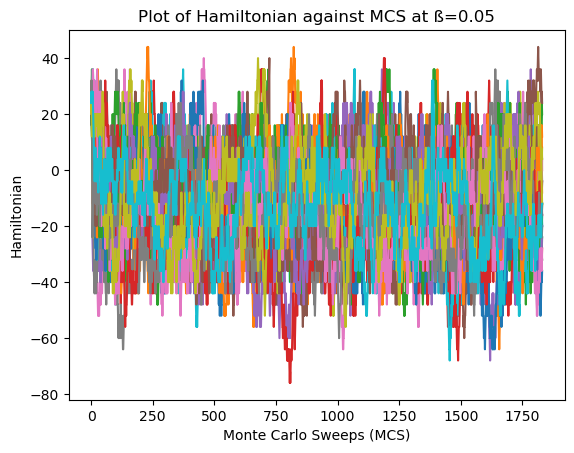

In [19]:
plotting_random_walks_timeseries_of_ensemble(t1=0,t2=t_last_sample,Y=H_timeseries_ensemble)
plt.show()

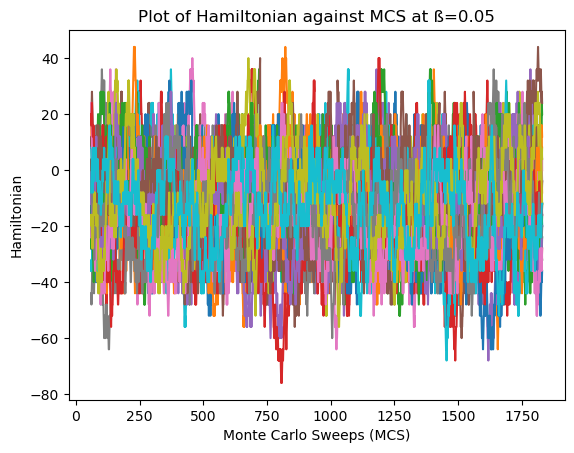

In [20]:
plotting_random_walks_timeseries_of_ensemble(t1=t_first_sample,t2=t_last_sample,Y=H_timeseries_ensemble)
plt.show()

In [21]:
sigma_ia=np.array(sample)[:,:len(sample[0])-1].T

m_i_a, u_a_i = message_passing_iteration_inv(sigma_ia,0.1,inv_temperature=2,seed=100,printing=True)

result=solution_inv_Ising(magnetization_from_cavity_fields(u_a_i))
accuracy_vector=1-np.abs((teacher_model_feature_mat[0].T)[0,:]-result)/2
accuracy=np.sum(accuracy_vector)/len(accuracy_vector)
print("Predicted Feature Vector:\n",result)
print("Truth Vector\n",(teacher_model_feature_mat[0].T)[0,:])
print("Accuracy: ",accuracy*100,"%")
q_result=q(teacher_model_feature_mat[0].T,result)
print("The overlap q =",q_result)

1 message passing iterations done.
2 message passing iterations done.
3 message passing iterations done.
4 message passing iterations done.
5 message passing iterations done.
6 message passing iterations done.
7 message passing iterations done.
8 message passing iterations done.
9 message passing iterations done.
10 message passing iterations done.
11 message passing iterations done.
12 message passing iterations done.
13 message passing iterations done.
14 message passing iterations done.
15 message passing iterations done.
Predicted Feature Vector:
 [-1. -1. -1. -1.  1.  1. -1. -1. -1.  1.  1.  1.  1. -1.  1. -1.  1.  1.
 -1. -1.  1.  1.  1. -1. -1. -1. -1. -1.  1.  1. -1.  1.  1.  1. -1.  1.
  1. -1.  1.  1.  1. -1. -1.  1.  1.  1. -1. -1. -1.  1. -1. -1. -1.  1.
  1.  1.  1. -1. -1. -1.]
Truth Vector
 [ 1  1  1 -1  1  1  1  1  1  1  1 -1 -1  1 -1  1 -1 -1 -1 -1  1 -1  1 -1
  1  1  1 -1 -1  1  1  1  1 -1 -1 -1  1  1 -1 -1 -1  1  1  1 -1  1  1  1
  1 -1 -1 -1  1  1 -1  1  1 -1 -1 -1]